# 04 Machine learning 03
# Pretrained model "mobilenet" with Random-Forest Classifier with Hyperparameter Tuning

# Procedure in general
1. Define model name and input data set path for images
2. Define Mobilenet as pretrained model to load from
3. Load data defined by step 1, and preprocess it with pretrained model; results in => new features per data set
4. Apply Random Forest classifier on featured datas from step 3 with 80 estimators
5. RandomizedSearchCV on Random Forest Classifier  
  5.1 Display wrong predictions  
  5.2 Display confusion matrix  
  5.3 Display class distribution  
6. Grid searchCV on Random Forest Classifier  
  6.1 Display wrong predictions  
  6.2 Display confusion matrix  
  6.3 Visualize score per parameter 


In [1]:
# Step 1
import JassSummarizer as js
from enum import Enum
from PIL import Image
import matplotlib.pyplot as plt 
from IPython.core.display import display, HTML
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import time
import re
import cv2
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import tensorflow.keras as keras
import tensorflow as tf


cnnModels=Enum("cnnModels","RMF224PT",start=0)                                                     # name model
trainedDataPaths=["ii","iii","iv"]                                                                 # available dataPaths
trainedDataPaths=["ii"]                                                                            # used Datapaths
img_graph = tf.Graph()                                                                             # Create graph
doFilePercent=100
results= pd.DataFrame([])

In [2]:
# Step 2
img_graph = tf.Graph()                                                                             # Create graph
with img_graph.as_default():
    module_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'         # library url
    feature_extractor = hub.Module(module_url)                                                     # Download module
    input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])                       # Create input placeholder
    imgs_features = feature_extractor(input_imgs)                                                  # A node with the features
    init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])               # Collect initializers
img_graph.finalize()                                                                               # Good practice: make the graph "read-only"

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [3]:
# Step 3
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"                                                              # disable GPU

# LOOP A
for cnnModel in cnnModels:                                                                             # leave loop even if just One model is defined
    mode=int(re.findall(r'\d+',cnnModel.name)[0])                                                      # get image dimension
    subMode=cnnModel.name[-2:]                                                                         # get subMode name
    size = (mode, mode)                                                                                # define size
    mlDimension = (mode,mode,3)                                                                        # define input shape
    fileListMaster= []                                                                                 # define fileListMaster
    pathMaster="_"                                                                                     # define pathMaster
    
    # LOOP B    
    for dataPath in trainedDataPaths:                                                                  # loop if more then one dataPath is used
        path = os.path.join(r".\images\02_data_preparation", "train_datascan_"+dataPath)               # generate path
        pathMaster += dataPath                                                                         # store path for later identifications
        fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == ".jpg"]

        if (doFilePercent !=100):                                                                      # shuffle and slice percentage
            a=fileList                                                                                 # temporary variable
            random.shuffle(a)                                                                          # shuffle entries
            percent=int(len(fileList)/100*doFilePercent)                                               # slice
            fileList=a[0:percent]                                                                      # reassign
            
        fileListMaster=fileListMaster+fileList                                                         # used on multiple dataPath
    path=pathMaster                                                                                    # reassign path selections
    fileList=fileListMaster                                                                            # reassign collected samples
    display(HTML(f"<h3>Analyzing Model {cnnModel.name}, by {mode}x{mode} with {len(fileList)} images</h3>"))   # inform about selected trainings data
    time.sleep(0.3)                                                                                    # short sleeper because of tqm output 

    X=[] ;y=[]                                                                                         # initialize
    modelData = {}                                                                                     # initialize

    with tqdm(total=len(fileList)) as pbar:                                                            # progess bar
        for fName in fileList:                                                                         # file/image iterator
            nameOnly=fName.split("\\")[-1]                                                             # extract filename
            cardId=nameOnly[0:2]                                                                       # extract cardId
            myImage=cv2.imread(fName,cv2.IMREAD_COLOR)                                                 # read imageDate
            data=js.analyzeScan(myImage,0.4)                                                           # preprocess image data
            frameOrg,mask,img_rect,res,crop_img, d = data                                              # separate results
            resized = cv2.resize(crop_img, size, interpolation = cv2.INTER_AREA)                       # resize to input shape
            r2=cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)                                                 # BGR 2 RGB color channel switch
            r3=js.backgroundDiffuser3(r2)                                                              # background optimization
            X.append(r3/255)                                                                           # normalize to fractions
            y.append([cardId.upper()])                                                                 # save cardId for later y_train or y_test
            pbar.update(1)                                                                             # update progress bar

    # split data from train, test, and fileName use stratified folds
    X_train_raw, X_test_raw, y_train_raw, y_test_raw ,y_train_file, y_test_file = train_test_split(
        np.array(X),np.array(y,dtype="O"), np.array(fileList), test_size=0.2, random_state=42, stratify=y)
    
    for dataSet in ["train","test"]:
        img_batch=eval("X_"+dataSet+"_raw")
        initialization_op = tf.global_variables_initializer()                                          # Init
        sess = tf.Session(graph=img_graph)                                                             # Create a session
        sess.run(init_op)                                                                              # Initialize it
        features = sess.run(imgs_features, feed_dict={input_imgs: img_batch})                          # Extract features
        key=f"X_{dataSet.replace('_raw','')}_features"                                                 # dictionary keyName set
        modelData[key]=features                                                                        # put array into dict
        key=f"y_{dataSet.replace('_raw','')}_targets"                                                  # set keyName for y values
        modelData[key]=eval("y_"+dataSet+"_raw")                                                       # put array into dict
        print(f"dataPath: {path}, dataset: {dataSet:6} with {features.shape[0]:6} entries, features: {features.shape[1]} ")                                                   
    np.savez("pretrainedFeatureData", dict=modelData)                                                  # save feature and targets as pickle file                                                      

    
    
    if 1==2:                                                                                           # manuel set to do persistence
        modelName=f"{cnnModel.name}_{path.split('_')[-1]}_{doFilePercent}"                             # compose filename
        modelFile=os.path.join(r".\model_save",modelName)                                              # get path and modelname
        model_json = model.to_json()                                                                   # convert to json 
        with open(modelFile+".json", "w") as json_file:                                                # get file handle
            json_file.write(model_json)                                                                # save into file
        model.save_weights(modelFile+".h5")                                                            # save weights
  

100%|██████████████████████████████████████████████████████████████████████████████| 1160/1160 [04:51<00:00,  3.97it/s]


dataPath: _ii, dataset: train  with    928 entries, features: 1280 
dataPath: _ii, dataset: test   with    232 entries, features: 1280 


# Random Forest with 80 Estimators

In [4]:
# Step 4
from sklearn.ensemble import RandomForestClassifier

X_train=modelData["X_train_features"]                                                                  # get train features
X_test=modelData["X_test_features"]                                                                    # get features from test set
y_train=modelData["y_train_targets"].reshape(-1)                                                       # targets from train
y_test=modelData["y_test_targets"].reshape(-1)                                                         # targets from test

model = RandomForestClassifier(n_estimators=80)                                                        # run with 80 estimaters
model.fit(X_train,y_train)                                                                             # do fitting
if 1==1:                                                                                               # output results
    for j, modelName in enumerate(["train","test"]):                                                   # do ir for train and test
        scoreRF=model.score(eval(f"X_{modelName}"), eval(f"y_{modelName}"))                            # get score
        print("Accuracy {0:7} set is {1:7.3f}%".format(modelName,scoreRF*100))                         # print score
    display(HTML("<h3>Random Forest score {0:7.3f}% with 80 estimators(Trees)</h3>".format(scoreRF)))

Accuracy train   set is 100.000%
Accuracy test    set is  93.534%


# RandomizedSearchCV on Random Forest Classifier

In [5]:
# Step 5
from sklearn.model_selection import RandomizedSearchCV
title="RandomizedSearchCV on Random Forest Classifier"
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 20)]                    # set range for n_estimators
max_features = ['auto', 'sqrt']                                                                    # set range for max features
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]                                       # set range for max depth
max_depth.append(None)                                                                             # 
min_samples_split = [2, 5, 10]                                                                     # set range of sample splist
min_samples_leaf = [1, 2, 4]                                                                       # set range of sample leafs
bootstrap = [True, False]                                                                          # set range of bootstrap
random_grid = {'n_estimators': n_estimators,                                                       # initialize grid with param ranges
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model = RandomForestClassifier()
rfCv = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, return_train_score=True)
rfCv.fit(X_train, y_train)
display(HTML(f"<h3>{title} {rfCv.cv_results_['mean_test_score'][rfCv.cv_results_['rank_test_score'].argmin()]:7.3f}% with {rfCv.best_params_['n_estimators']} estimators(Trees)</h3>"))
display(HTML(f"<h3>Best params</h3>"))
for k in rfCv.best_params_ :
    print( f"Param {k:17} = {rfCv.best_params_[k]}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.7min finished
C:\Users\tralore\Anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Param n_estimators      = 426
Param min_samples_split = 5
Param min_samples_leaf  = 1
Param max_features      = sqrt
Param max_depth         = 40
Param bootstrap         = False


### Apply model on test data and print wrong predictions

In [6]:
# Step 5.1
y_predicted=rfCv.predict(X_test)                                                                       # do predictions
cnt=0                                                                                                  # initialize counter
for j, predict in enumerate(y_predicted):                                                              # enmuerate results
    if predict != y_test[j]:                                                                           # check if successful
        cnt=cnt+1                                                                                      # increase errors
        print(f"predicted was {predict} but in reality it was {y_test[j]}")                            # print wrong prediction
print(f"{cnt} wrong out of {j} = {100/j*cnt:7.3f}%")                                                   # print summary

predicted was C5 but in reality it was D6
predicted was C0 but in reality it was C1
predicted was A3 but in reality it was A1
predicted was B0 but in reality it was B1
predicted was D4 but in reality it was C4
predicted was D8 but in reality it was C5
predicted was D1 but in reality it was D2
predicted was A6 but in reality it was A5
predicted was A4 but in reality it was A5
predicted was D1 but in reality it was D3
predicted was D3 but in reality it was D2
predicted was A2 but in reality it was A1
12 wrong out of 231 =   5.195%


In [7]:
# Step 5.2 
import sklearn.metrics

pd.options.display.max_columns = None                                                                  # disable column hiding
display(HTML("<h1>Confusion Matrix</h1>"))                                                             # print title

y_true = y_test                                                                                        # get data
y_pred = y_predicted                                                                                   # get data
newColumn=[]                                                                                           # initialize

r = sklearn.metrics.confusion_matrix(y_true, y_pred)                                                   # get confusion matrix
cmDf=pd.DataFrame(r.astype("O"))                                                                       # as string type
cmDf=cmDf.replace(0,".")                                                                               # for better visualizing replace 0 with .
for card in js.JassCN2._member_names_:                                                                 # make nice column names
    newColumn=newColumn+[card]                                                                         # next Card Id to column
cmDf.columns=newColumn                                                                                 # apply new column names
cmDf                                                                                                   # display dataframe and set column header
cmDf.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '10px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(-90deg)'),
                        ])])

,A0,A1,A2,A3,A4,A5,A6,A7,A8,B0,B1,B2,B3,B4,B5,B6,B7,B8,C0,C1,C2,C3,C4,C5,C6,C7,C8,D0,D1,D2,D3,D4,D5,D6,D7,D8
0,5,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
1,.,2,1,1,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2,.,.,4,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
3,.,.,.,6,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
4,.,.,.,.,7,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
5,.,.,.,.,1,5,1,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,7,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,7,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,5,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
9,.,.,.,.,.,.,.,.,.,5,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.


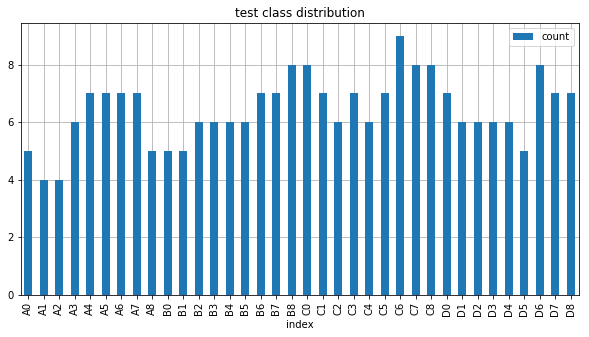

In [8]:
# Step 5.3 
pd.DataFrame(pd.Series(y_test).value_counts(),columns=["count"]).reset_index().sort_values("index").set_index("index").plot(kind="bar",
        grid=True,figsize=(10,5),title="test class distribution",zorder=10)


 # Grid searchCV on Random Forest Classifier

In [9]:
# Step 6
from sklearn.model_selection import GridSearchCV

title="Grid searchCV on Random Forest Classifier"                                                      # set title
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [ 100, 110, 120, 130],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 3, 4, 5, 6, ],
    'n_estimators': [500, 600, 700, 800]
}

# Create a based model
model = RandomForestClassifier()
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 3, return_train_score=True)
grid_search.fit(X_train, y_train)
display(HTML(f"<h3>{title} {grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['rank_test_score'].argmin()]:7.3f}% with {grid_search.best_params_['n_estimators']} estimators(Trees)</h3>"))
display(HTML(f"<h3>Best params</h3>"))
for k in grid_search.best_params_ :
    print( f"Param {k:17} = {grid_search.best_params_[k]}")

Fitting 3 folds for each of 640 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  6.0min finished
C:\Users\tralore\Anaconda3\envs\exts-ml\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Param bootstrap         = False
Param max_depth         = 100
Param max_features      = 3
Param min_samples_leaf  = 1
Param min_samples_split = 2
Param n_estimators      = 600


### Apply model on test data and print wrong predictions

In [10]:
# Step 6.1
y_predicted=grid_search.best_estimator_.predict(X_test)                                                                       # do predictions
cnt=0                                                                                                  # initialize counter
for j, predict in enumerate(y_predicted):                                                              # enmuerate results
    if predict != y_test[j]:                                                                           # check if successful
        cnt=cnt+1                                                                                      # increase errors
        print(f"predicted was {predict} but in reality it was {y_test[j]}")                            # print wrong prediction
print(f"{cnt} wrong out of {j} = {100/j*cnt:7.3f}%")                                                   # print summary

predicted was C0 but in reality it was C1
predicted was A3 but in reality it was A1
predicted was B0 but in reality it was B1
predicted was D4 but in reality it was C4
predicted was D8 but in reality it was C5
predicted was D3 but in reality it was D2
predicted was A4 but in reality it was A5
predicted was D1 but in reality it was D3
predicted was B1 but in reality it was B3
predicted was D3 but in reality it was D2
predicted was A3 but in reality it was A1
11 wrong out of 231 =   4.762%


In [11]:
# Step 6.2 
import sklearn.metrics

pd.options.display.max_columns = None                                                                  # disable column hiding
display(HTML("<h3>Confusion Matrix</h3>"))                                                             # print title

y_true = y_test                                                                                        # get data
y_pred = y_predicted                                                                                   # get data
newColumn=[]                                                                                           # initialize

r = sklearn.metrics.confusion_matrix(y_true, y_pred)                                                   # get confusion matrix
cmDf=pd.DataFrame(r.astype("O"))                                                                       # as string type
cmDf=cmDf.replace(0,".")                                                                               # for better visualizing replace 0 with .
for card in js.JassCN2._member_names_:                                                                 # make nice column names
    newColumn=newColumn+[card]                                                                         # next Card Id to column
cmDf.columns=newColumn                                                                                 # apply new column names
cmDf                                                                                                   # display dataframe and set column header
cmDf.style.set_table_styles(
    [dict(selector="th",props=[('max-width', '10px')]),
        dict(selector="th.col_heading",
                 props=[("writing-mode", "vertical-rl"), 
                        ('transform', 'rotateZ(-90deg)'),
                        ])])

,A0,A1,A2,A3,A4,A5,A6,A7,A8,B0,B1,B2,B3,B4,B5,B6,B7,B8,C0,C1,C2,C3,C4,C5,C6,C7,C8,D0,D1,D2,D3,D4,D5,D6,D7,D8
0,5,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
1,.,2,.,2,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
2,.,.,4,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
3,.,.,.,6,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
4,.,.,.,.,7,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
5,.,.,.,.,1,6,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,7,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,7,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,5,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.
9,.,.,.,.,.,.,.,.,.,5,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.


In [12]:
import winsound                                              # signalize accepted prediction
duration = 3000                                              # milliseconds
freq = 1440                                                  # Hz
winsound.Beep(freq, duration)  

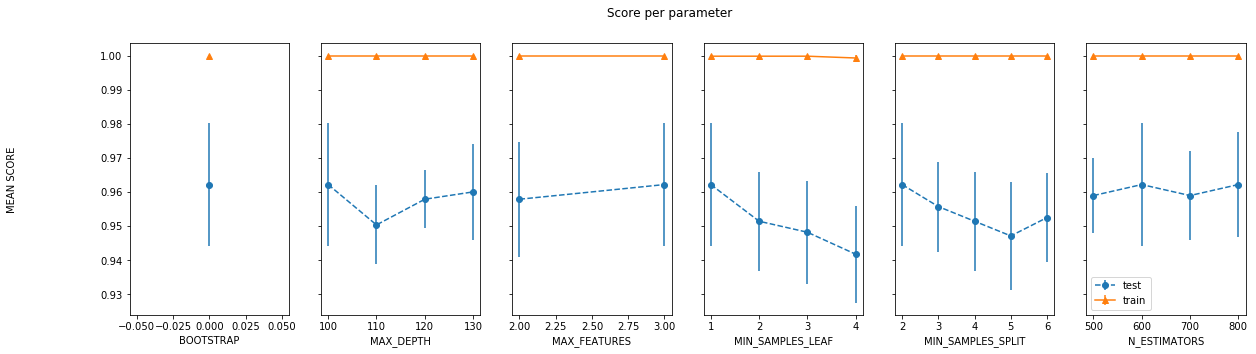

In [13]:
# Step 6.3
# code from stackoverflow
# https://stackoverflow.com/a/57013458
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()
    
display(HTML("<h3>Hyperparameter Score chart</h3>"))   
plot_search_results(grid_search)

## Best Performance

Do list the best results on all ever taken ML tasks, I'm going to iterate through all ML*.csv results and add them to a big result table. Results from the datascan_iii set I skip, as I do not use the mobile phone at the end for the scan procedure. The added results are identified by the file date and the source file name. This identifies the parameter that have been used to generate the appropriate result entry.


In [14]:
import os
import time
path=r"."
dr=pd.DataFrame()
fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if (os.path.splitext(f)[1] == '.csv' 
                                    and os.path.split(f)[1].startswith("ML") and not os.path.split(f)[1].endswith("iii.csv"))]
for file in fileList:
    temp=pd.read_csv(file)
    temp["source"]=file
    temp["date"]=int(os.path.getmtime(file))
    temp['date'] = pd.to_datetime(temp['date'],unit='s')
    dr=dr.append(temp,sort=False)
dr.reset_index(drop=True, inplace=True)
dd=dr[dr["set"]== "test"].sort_values(["acc","loss"],ascending=[False,True])[["model","acc","loss","set","source","date"]]
dd.reset_index(drop=True, inplace=True)
dd.head(10)

,model,acc,loss,set,source,date
0,CNN64MA,0.998,0.008,test,.\ML_results_v_99.csv,2021-03-21 12:40:26
1,CNN224,0.998,0.009,test,.\ML_results_v.csv,2021-03-16 22:47:20
2,CNN224,0.998,0.009,test,.\ML_results_v_100.csv,2021-03-16 22:49:05
3,CNN64,0.998,0.010,test,.\ML_results_v_80.csv,2021-03-12 16:08:37
4,CNN64,0.998,0.010,test,.\ML_results_v_99.csv,2021-03-21 12:40:26
5,CNN224,0.998,0.011,test,.\ML_results_v_99.csv,2021-03-21 12:40:26
6,CNN64DG,0.997,0.013,test,.\ML_results_v_80.csv,2021-03-12 16:08:37
7,CNN224,0.997,0.014,test,.\ML_results_v_80.csv,2021-03-12 16:08:37
8,CNN64DG,0.997,0.014,test,.\ML_results_v_99.csv,2021-03-21 12:40:26
9,CNN224DG,0.997,0.014,test,.\ML_results_v_99.csv,2021-03-21 12:40:26
